In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import pickle 
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pi = 3.14159
data = pickle.load( open( "camera_calibration.pkl", "rb" ) )
mtx_camera = data[0]
dist_camera = data[1]

%matplotlib inline

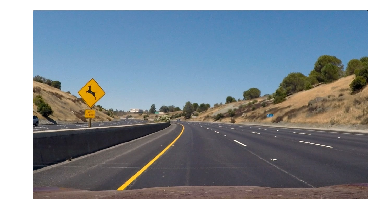

In [2]:
#reading in an image
image = mpimg.imread('test_images/test2.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')

plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
plt.axis('off');

In [3]:
kernel_size = 5

def get_val(y,pol_a):
    return pol_a[0]*y**2+pol_a[1]*y+pol_a[2]

def draw_pw_lines(img,pts,color):
    pts = np.int_(pts)
    for i in range(10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1, y1), (x2, y2),color,50)
        
def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
def gaussian_blur(img, kernel=5):
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    if orient=='x':
        img_s = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s>=thresh[0]) & (img_s<=thresh[1]) ]=1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output
    
def GaussianC_Adaptive_Threshold(img,kernel,cut_val):

    img_cut = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,kernel,cut_val)
    return img_cut

def warp_image(img,src,dst,img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped,M,Minv

def sobel_combined(image):
    img_g_mag = mag_thresh(image,3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image,'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image,'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x == 1) & (img_abs_y == 1)) | \
               ((img_g_mag == 1) & (img_d_mag == 1))] = 1
    return sobel_combined


def color_mask(hsv,low,high):
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def moving_average(a, n=3):
    # Moving average
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_curvature(pol_a,y_pt):
    A = pol_a[0]
    B = pol_a[1]
    R_curve = (1+(2*A*y_pt+B)**2)**1.5/2/A
    return R_curve

def stack_arr(arr):
    return np.stack((arr, arr,arr), axis=2)

In [4]:
def pipeline_process_diagnosis(image):
    
    global left_fit_prev   
    global right_fit_prev
    global col_R_prev
    global col_L_prev
    global set_prev
    

    
    image = undistort_image(image, mtx_camera , dist_camera )
    image = gaussian_blur(image, kernel=5)
    img_size = np.shape(image)
    
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .25*np.uint(img_size[1]/2)
    ctr_window = c_window + .25*np.uint(img_size[1]/2)
    cbl_window = c_window - 1*np.uint(img_size[1]/2)
    cbr_window = c_window + 1*np.uint(img_size[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],
                      [ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])
    warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))
    
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])

    
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    image_cmb = cv2.bitwise_or(wraped2,wraped3)
    image_cmb = gaussian_blur(image_cmb,25)
    
    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1
    
    img_R = np.zeros_like(image_cmb1)
    img_L = np.zeros_like(image_cmb1)
    
    #image_cmb1 = mask_lane
    img = gaussian_blur(img,5)
    img_size = np.shape(img)
    mov_filtsize = int(img_size[1]/50.)
    mean_lane = np.mean(img[img_size[1]//2:,:],axis=0)
    mean_lane = moving_average(mean_lane,mov_filtsize)
        
    col_R = (255,255,255)
    col_L = (255,255,255)
    arg_fsb = np.argwhere(mean_lane>.05)
    
    arg_fsb_L = arg_fsb[arg_fsb<img_size[1]/2.]
    if len(arg_fsb_L)==0:
        left_fit = left_fit_prev
        col_L = col_L_prev
    else:
        arg_fsb_L_min = np.min(arg_fsb_L)
        arg_fsb_L_max = np.max(arg_fsb_L)
        
        img_L = np.copy(image_cmb1)
        img_L[:,0:arg_fsb_L_min] = 0
        img_L[:,arg_fsb_L_max:img_size[1]] = 0
        img_L = gaussian_blur(img_L,25)
    
        vals = np.argwhere(img_L>.5)
        if len(vals)==0:
            left_fit = left_fit_prev
            col_L = col_L_prev
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            left_fit = np.polyfit(all_x, all_y, 2)
            if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:
                col_L = (255,255,0)
    arg_fsb_R = arg_fsb[arg_fsb>img_size[1]/2.]
    if len(arg_fsb_R)<10:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        arg_fsb_R_min = np.min(arg_fsb_R)
        arg_fsb_R_max = np.max(arg_fsb_R)
        
        img_R = np.copy(image_cmb1)
        img_R[:,0:arg_fsb_R_min] = 0
        img_R[:,arg_fsb_R_max:img_size[1]] = 0
        img_R = gaussian_blur(img_R,25)
    
        vals = np.argwhere(img_R>.5)
        if len(vals)<10:
            right_fit = right_fit_prev
            col_R = col_R_prev
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            right_fit = np.polyfit(all_x, all_y, 2)
            if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
                col_R = (255,255,0)
            
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit
        
        
    err_p_R = np.sum((right_fit-right_fit_prev)**2)/np.sum(right_fit_prev**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>0.05:
        right_fit = right_fit_prev
        left_fit =  left_fit_prev
    else:
        right_fit = .05*right_fit+.95*right_fit_prev
        left_fit =  .05* left_fit+.95* left_fit_prev
    
        
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))
    
    
    left_bot = get_val(img_size[0],left_fit)
    right_bot = get_val(img_size[0],right_fit)
    
    val_center = (left_bot+right_bot)/2.0
    
    dist_offset = val_center - img_size[1]/2
    dist_offset = np.round(dist_offset/2.81362,2)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    if dist_offset>30:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))
        

    # Draw the lane onto the warped blank image
    

   
    
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    left_curve = get_curvature(left_fit,img_size[0]/2)
    Right_curve = get_curvature(right_fit,img_size[0]/2)
    
    str_curv = 'Curvature: Right = ' + str(np.round(Right_curve,2)) + ', Left = ' + str(np.round(left_curve,2)) 
    #print(str_curv)
    
    
    #print(left_bot,right_bot,str_offset)
    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L

    #return result    # using cv2 for drawing text in diagnostic pipeline.
    font = cv2.FONT_HERSHEY_COMPLEX
    middlepanel = np.zeros((120, 1280, 3), dtype=np.uint8)
    cv2.putText(middlepanel, str_curv, (30, 60), font, 1, (255,0,0), 2)
    cv2.putText(middlepanel, str_offset, (30, 90), font, 1, (255,0,0), 2)


    # assemble the screen example
    diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
    diagScreen[0:720, 0:1280] = result
    diagScreen[0:240, 1280:1600] = cv2.resize(warped, (320,240), interpolation=cv2.INTER_AREA) 
    diagScreen[0:240, 1600:1920] = cv2.resize(stack_arr(mask_lane), (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[240:480, 1280:1600] = cv2.resize(apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high), (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[240:480, 1600:1920] = cv2.resize(apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high), (320,240), interpolation=cv2.INTER_AREA)*4
    diagScreen[600:1080, 1280:1920] = cv2.resize(color_warp, (640,480), interpolation=cv2.INTER_AREA)*4
    diagScreen[720:840, 0:1280] = middlepanel
    diagScreen[840:1080, 0:320] = cv2.resize(newwarp, (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 320:640] = cv2.resize(stack_arr(255*img_R), (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 640:960] = cv2.resize(stack_arr(255*img_L), (320,240), interpolation=cv2.INTER_AREA)
    diagScreen[840:1080, 960:1280] = cv2.resize(stack_arr(255*image_cmb1), (320,240), interpolation=cv2.INTER_AREA)
    return diagScreen

In [7]:
def pipeline_process(image):
    
    global left_fit_prev   
    global right_fit_prev
    global col_R_prev
    global col_L_prev
    global set_prev
    

    
    image = undistort_image(image, mtx_camera , dist_camera )
    image = gaussian_blur(image, kernel=5)
    img_size = np.shape(image)
    
    ht_window = np.uint(img_size[0]/1.5)
    hb_window = np.uint(img_size[0])
    c_window = np.uint(img_size[1]/2)
    ctl_window = c_window - .25*np.uint(img_size[1]/2)
    ctr_window = c_window + .25*np.uint(img_size[1]/2)
    cbl_window = c_window - 1*np.uint(img_size[1]/2)
    cbr_window = c_window + 1*np.uint(img_size[1]/2)
    src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],
                      [ctr_window,ht_window],[ctl_window,ht_window]])
    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])
    warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))
    
    image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)

    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])

    
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_lane = cv2.bitwise_or(mask_yellow,mask_white) 
    
    image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)

    img_gs = image_HLS[:,:,1]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
    wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    img_gs = image_HLS[:,:,2]
    img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,255))
    img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,255))
    wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
    
    image_cmb = cv2.bitwise_or(wraped2,wraped3)
    image_cmb = gaussian_blur(image_cmb,5)
    
    image_cmb1 = np.zeros_like(image_cmb)
    image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1
           
    col_R = (255,255,255)
    col_L = (255,255,255)
    arg_fsb = np.argwhere(mask_lane>.05)
    
    arg_fsb_L = arg_fsb[arg_fsb<img_size[1]/2.]
    if len(arg_fsb_L)==0:
        left_fit = left_fit_prev
        col_L = col_L_prev
    else:
        arg_fsb_L_min = np.min(arg_fsb_L)
        arg_fsb_L_max = np.max(arg_fsb_L)
        
        img_L = np.copy(image_cmb1)
        img_L[:,0:arg_fsb_L_min] = 0
        img_L[:,arg_fsb_L_max:img_size[1]] = 0
        img_L = gaussian_blur(img_L,25)
    
        vals = np.argwhere(img_L>.5)
        if len(vals)==0:
            left_fit = left_fit_prev
            col_L = col_L_prev
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            left_fit = np.polyfit(all_x, all_y, 2)
            if np.sum(cv2.bitwise_and(img_L,mask_yellow))>1000:
                col_L = (255,255,0)
    arg_fsb_R = arg_fsb[arg_fsb>img_size[1]/2.]
    if len(arg_fsb_R)<10:
        right_fit = right_fit_prev
        col_R = col_R_prev
    else:
        arg_fsb_R_min = np.min(arg_fsb_R)
        arg_fsb_R_max = np.max(arg_fsb_R)
        
        img_R = np.copy(image_cmb1)
        img_R[:,0:arg_fsb_R_min] = 0
        img_R[:,arg_fsb_R_max:img_size[1]] = 0
        img_R = gaussian_blur(img_R,25)
    
        vals = np.argwhere(img_R>.5)
        if len(vals)<10:
            right_fit = right_fit_prev
            col_R = col_R_prev
        else:
            all_x = vals.T[0]
            all_y =vals.T[1]
            right_fit = np.polyfit(all_x, all_y, 2)
            if np.sum(cv2.bitwise_and(img_R,mask_yellow))>1000:
                col_R = (255,255,0)
            
    if set_prev == 0:
        set_prev = 1
        right_fit_prev = right_fit
        left_fit_prev  = left_fit
        
        
    err_p_R = np.sum((right_fit-right_fit_prev)**2)/np.sum(right_fit_prev**2)
    err_p_R = np.sqrt(err_p_R)
    if err_p_R>0.05:
        right_fit = right_fit_prev
        left_fit =  left_fit_prev
    else:
        right_fit = .05*right_fit+.95*right_fit_prev
        left_fit =  .05* left_fit+.95* left_fit_prev
    
    
    
    right_y = np.arange(11)*img_size[0]/10
    right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]

    left_y = np.arange(11)*img_size[0]/10
    left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]
    
    warp_zero = np.zeros_like(image_cmb1).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))

    left_bot = get_val(img_size[0],left_fit)
    right_bot = get_val(img_size[0],right_fit)
    
    val_center = (left_bot+right_bot)/2.0
    
    dist_offset = val_center - img_size[1]/2
    dist_offset = np.round(dist_offset/2.81362,2)
    str_offset = 'Lane deviation: ' + str(dist_offset) + ' cm.'
    
    if dist_offset>30:
        cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
    else:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 255))
        
    
   
    
    draw_pw_lines(color_warp,np.int_(pts_left),col_L)
    draw_pw_lines(color_warp,np.int_(pts_right),col_R)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    
    newwarp = cv2.warpPerspective(color_warp, Minv_warp, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.5, 0)
    
    left_curve = get_curvature(left_fit,img_size[0]/2)
    Right_curve = get_curvature(right_fit,img_size[0]/2)
    
    str_curv = 'Curvature: Right = ' + str(np.round(Right_curve,2)) + ', Left = ' + str(np.round(left_curve,2)) 
    #print(str_curv)
    font = cv2.FONT_HERSHEY_COMPLEX    
    if dist_offset<30:
        cv2.putText(result, str_curv, (30, 60), font, 1, (0,255,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (0,255,0), 2)
    else:
        cv2.putText(result, str_curv, (30, 60), font, 1, (255,0,0), 2)
        cv2.putText(result, str_offset, (30, 90), font, 1, (255,0,0), 2)
    
        
    right_fit_prev = right_fit
    left_fit_prev  = left_fit
    col_R_prev = col_R
    col_L_prev = col_L
    return result

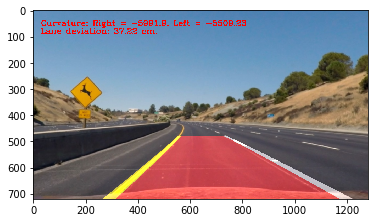

In [8]:
set_prev = 0

result_pipe = pipeline_process(image)
plt.imshow(result_pipe)

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
set_prev = 0

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4");
white_clip = clip1.fl_image(pipeline_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False);

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [02:49<00:00,  7.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 50s
